# Aggregate Profitability Analysis

This notebook uses the data from my thesis (without any filtering) to see if the aggregate profitability of public firms relates with macroeconomic aggregate measures like GDP, GVA, Corporate Profits, and more...

## Importing

### Importing Relevant Packages

In [1]:
import numpy as np
import pandas as pd
import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
from statsmodels.regression.rolling import RollingOLS

# to access Macro data
def FRED(code):
    fred_url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id='
    df = pd.read_csv(fred_url + code)
    if 'DATE' in df.columns:
        df['DATE'] = df.apply(lambda row: datetime.date.fromisoformat(row.DATE), axis=1)
        df['DATE'] = pd.to_datetime(df['DATE'])
        df.set_index('DATE', inplace=True)
    time.sleep(2)  # So that I don't get blocked through excessive requests
    return df

# to calculate percent differences correctly
def pct_diff(series: pd.Series, periods: int = 1) -> pd.Series:
    """
    Calculate the percent difference of a pandas series.

    Parameters
    ----------
    series : pandas.Series
        Input series to calculate percent difference from.
    periods : int, default=1
        Number of periods to shift the series by.

    Returns
    -------
    pandas.Series
        Series with percent difference from the shifted series.

    """
    shifted_series = series.shift(periods)
    rs = series / shifted_series.where(shifted_series >= 0, np.nan) - 1
    return rs

# to quickly make a correlation matrix heatmap
def correlmap(data):
    data_correlation = data.corr()    
    sns.heatmap(data_correlation, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
    plt.show()
    display(pd.DataFrame(data_correlation.sum(), columns=['Sum of Correlations']))


def cqtr_to_date(cqtr, end=False):
    # cqtr is string
    stryear = cqtr[:4]
    quarter = int(cqtr[-1:])
    if end:
        month = quarter * 3
        strmonth = str(month)
        days = '30' if quarter == 2 or quarter == 3 else 31
        strdays = str(days)
    else:
        month = quarter * 3 - 2
        strmonth = str(month)
        strdays = '01'
    if len(strmonth) == 1:
            strmonth = '0' + strmonth
    return np.datetime64(stryear + '-' + strmonth + '-' + strdays)



from scipy.stats import pearsonr

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues


In [2]:
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['font.family'] = 'NewComputerModern10Book'
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['xtick.bottom'] = False
matplotlib.rcParams['ytick.left'] = False

def comma(x, pos):
    return f'{x:,.0f}'

#plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

### Importing Calculated Data

In [3]:
tdfs = pd.read_csv('../Data/regressions_results_2024-03-20.csv', 
                   dtype={
                       'gvkey': np.unicode_,
                       'datadate': np.unicode_,
                       'fyearq': 'float32',
                       'fqtr': 'float32',
                       'indfmt': np.unicode_,
                       'consol': np.unicode_,
                       'popsrc': np.unicode_,
                       'datafmt': np.unicode_,
                       'tic': np.unicode_,
                       'cusip': np.unicode_,
                       'conm': np.unicode_,
                       'curcdq': np.unicode_,
                       'datacqtr': np.unicode_,
                       'datafqtr': np.unicode_,
                       'naics': np.unicode_,
                       'sic': np.unicode_,
                       'ggroup': np.unicode_,
                       'gind': np.unicode_,
                       'gsector': np.unicode_,
                       'gsubind': np.unicode_,
                       'cik': np.unicode_,
                       'costat': np.unicode_,
                       'actq': 'float64',
                       'atq': 'float64',
                       'ceqq': 'float64',
                       'chq': 'float64',
                       'cshfdq': 'float64',
                       'cshoq': 'float64',
                       'cshprq': 'float64',
                       'dlcq': 'float64',
                       'dlttq': 'float64',
                       'dpactq': 'float64',
                       'dpq': 'float64',
                       'icaptq': 'float64',
                       'lctq': 'float64',
                       'niq': 'float64',
                       'oiadpq': 'float64',
                       'oibdpq': 'float64',
                       'piq': 'float64',
                       'revtq': 'float64',
                       'teqq': 'float64',
                       'txtq': 'float64',
                       'xintq': 'float64',
                       'xrdq': 'float64',
                       'dvy': 'float64',
                       'cik': 'float64',
                       'mktvalq': 'float64',
                       'prccq': 'float64', 
                       'tid': np.unicode_,
                       'qid': np.unicode_,
                       'beta': np.float64,
                       'beta_se': np.float64,
                       'alpha': np.float64,
                       'alpha_se': np.float64,
                       'r2': np.float64,
                       'DGS1': np.float64,
                       'rfr': np.float64,
                       'Market_Cap': np.float64,
                       'Cash': np.float64,
                       'Debt': np.float64,
                       'Net_Debt': np.float64,
                       'Long_Term_Debt': np.float64,
                       'Enterprise_Value': np.float64,
                       'Current_Assets': np.float64,
                       'Current_Liabilities': np.float64,
                       'Current_Liabilities_minus_ST_Debt': np.float64,
                       'Current_Ratio': np.float64,
                       'Common_Equity': np.float64,
                       'NI': np.float64,
                       'Pretax_Income': np.float64,
                       'EBIT': np.float64,
                       'EBITDA': np.float64,
                       'Taxes': np.float64,
                       'Tax_Rate': np.float64,
                       'Revenue': np.float64,
                       'NOPAT': np.float64,
                       'Total_Costs': np.float64,
                       'Total_Costs_inc_t': np.float64,
                       'RnD': np.float64,
                       'Assets': np.float64,
                       'Invested_Capital': np.float64,
                       'tobins_q': np.float64,
                       'EBIT_margin': np.float64,
                       'ROIC': np.float64,
                       'ROA': np.float64,
                       'ROE': np.float64,
                       'beta_ul': np.float64,
                       'RR': np.float64,
                       'qRR': np.float64,
                       'RRIC': np.float64,
                       'RREV': np.float64,
                       'Excess_Profit': np.float64,
                       'Total_Costs_inc_RRIC': np.float64,
                       'Total_Costs_inc_RREV': np.float64,
                       'Market_Cap_Growth': np.float64,
                       'Enterprise_Value_Growth': np.float64,
                       'EBIT_Growth': np.float64,
                       'Revenue_Growth': np.float64,
                       'Total_Costs_Growth': np.float64,
                       'Total_Costs_inc_t_Growth': np.float64,
                       'Assets_Growth': np.float64,
                       'Invested_Capital_Growth': np.float64,
                       'tobins_q_Growth': np.float64,
                       'ROIC_Growth': np.float64,
                       'ROA_Growth': np.float64,
                       'RRIC_Growth': np.float64,
                       'RREV_Growth': np.float64,
                       'Excess_Profit_Growth': np.float64,
                       'Total_Costs_inc_RRIC_Growth': np.float64,
                       'naics1': np.unicode_,
                       'naics2': np.unicode_,
                       'naics3': np.unicode_,
                       'naics4': np.unicode_,
                       'naics5': np.unicode_,
                       'naics6': np.unicode_,
                       'mktshare1': np.float64,
                       'mktshare2': np.float64,
                       'mktshare3': np.float64,
                       'mktshare4': np.float64,
                       'mktshare5': np.float64,
                       'mktshare6': np.float64,
                       'hhi1': np.float64,
                       'hhi2': np.float64,
                       'hhi3': np.float64,
                       'hhi4': np.float64,
                       'hhi5': np.float64,
                       'hhi6': np.float64,
                       'tobins_q_agg': np.float64,
                       'ROIC_agg': np.float64,
                       'ROA_agg': np.float64,
                       'RR_agg': np.float64,
                       '?': np.float64,
                       'price_cost_margin': np.float64,
                       'price_cost_margin_se': np.float64,
                       'price_cost_margin_na': np.float64,
                       'lerner': np.float64,
                       'lerner_se': np.float64,
                       'lerner_na': np.float64,
                       'mroic': np.float64,
                       'mroic_se': np.float64,
                       'mroic_na': np.float64,
                       'ar_coef': np.float64,
                       'ar_coef_se': np.float64,
                       'ar_int': np.float64,
                       'ar_int_se': np.float64,
                       'ar_na': np.float64
                   }, index_col=0
                  )
tdfs['datadate'] = pd.to_datetime(tdfs.datadate)
tdfs['cyear'] = tdfs.datadate.apply(lambda row: row.year)

tdfs['hhi_gsubind'] = tdfs['hhi_gsubind'].apply(lambda hhi: hhi if hhi < 1 else 1)
tdfs['mktshare_gsubind'] = tdfs['mktshare_gsubind'].apply(lambda ms: ms if ms < 1 else 1)

List of current public firms
(have a beta from 2Q23)

In [4]:
current_public_gvkeys = tdfs[tdfs.datacqtr == '2023Q2'][['beta','gvkey']].dropna().gvkey.unique()
print('Total dataframe:', tdfs.gvkey.nunique(), 'firms;', len(tdfs), 'observations')
print('Currently public:', len(current_public_gvkeys), 'firms;', len(tdfs[tdfs.gvkey.isin(current_public_gvkeys)]))

Total dataframe: 28721 firms; 1432601 observations
Currently public: 4106 firms; 399976


## Data Transformation

### Aggregation Columns

In [11]:
agg_cols = ['Revenue', 'EBITDA', 'EBIT', 'Pretax_Income', 'NI', 'Excess_Profit', 'Assets', 'Debt', 'Enterprise_Value']
agg_cols_names = {col:col for col in agg_cols}
agg_cols_names['Enterprise_Value'] = 'EV'
agg_cols_names['Excess_Profit'] = 'Π'
agg_cols_names['Pretax_Income'] = 'EBT'

### Naive Aggregation

Observations: 1307925 ;   Firms: 27438


,Revenue,EBITDA,EBIT,Pretax_Income,NI,Excess_Profit,Assets,Debt,Enterprise_Value,datacqtr
datacqtr,,,,,,,,,,
2012-01-01,6269109.890,9.862185e+05,7.494230e+05,615555.995,403893.134,149246.533107,5.437446e+07,1.831452e+07,3.576565e+07,2012Q1
2012-04-01,6587204.321,1.168777e+06,8.851982e+05,636907.364,420594.903,202194.709381,5.827151e+07,1.872943e+07,3.679653e+07,2012Q2
2012-07-01,6234716.439,9.997312e+05,7.453551e+05,551583.954,359408.007,132614.755491,5.499458e+07,1.833301e+07,3.573609e+07,2012Q3
2012-10-01,7384801.318,1.161356e+06,8.370801e+05,548785.241,397749.559,104575.074950,6.095137e+07,2.005602e+07,4.038266e+07,2012Q4
2013-01-01,6167587.841,1.006357e+06,7.469187e+05,619231.333,494436.535,117409.121298,5.371662e+07,1.829214e+07,3.755014e+07,2013Q1
2013-04-01,6792162.208,1.200636e+06,8.833918e+05,714820.965,483036.051,150825.488063,5.989605e+07,1.884168e+07,4.036221e+07,2013Q2
2013-07-01,6383681.273,1.068689e+06,7.854059e+05,633794.904,492503.790,126532.645930,5.546997e+07,1.802277e+07,3.932599e+07,2013Q3
2013-10-01,7380438.137,1.232669e+06,8.921326e+05,641340.173,426612.614,233498.910619,6.169140e+07,1.995589e+07,4.641917e+07,2013Q4
2014-01-01,6464599.777,1.035673e+06,7.625387e+05,606417.441,476688.478,181084.068719,5.661920e+07,1.810875e+07,4.152143e+07,2014Q1


,Revenue,EBITDA,EBIT,Pretax_Income,NI,Excess_Profit,Assets,Debt,Enterprise_Value
count,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,44.000000,44.000000,4.400000e+01,4.400000e+01,4.400000e+01
mean,6.805698e+06,1.165048e+06,8.269068e+05,6.156404e+05,453653.007614,152327.463349,6.327459e+07,2.097495e+07,5.255167e+07
std,8.234483e+05,1.955943e+05,1.719461e+05,1.972945e+05,162375.002685,102946.451769,7.241456e+06,2.526140e+06,1.228398e+07
min,5.532499e+06,7.677407e+05,4.123182e+05,-1.087509e+04,-30537.031000,-47400.137871,5.371662e+07,1.802277e+07,3.573609e+07
25%,6.245432e+06,1.025361e+06,7.434959e+05,5.388638e+05,377035.065500,90963.170472,5.718348e+07,1.884956e+07,4.349973e+07
50%,6.495425e+06,1.140362e+06,7.990156e+05,6.203808e+05,441801.098000,125385.772860,6.172032e+07,2.011477e+07,4.914166e+07
75%,7.360136e+06,1.283148e+06,9.229573e+05,7.003395e+05,530869.790750,195246.783063,6.725638e+07,2.239275e+07,5.924557e+07
max,9.233123e+06,1.625859e+06,1.222454e+06,1.075203e+06,856378.754000,475894.681065,8.005299e+07,2.669767e+07,8.502401e+07


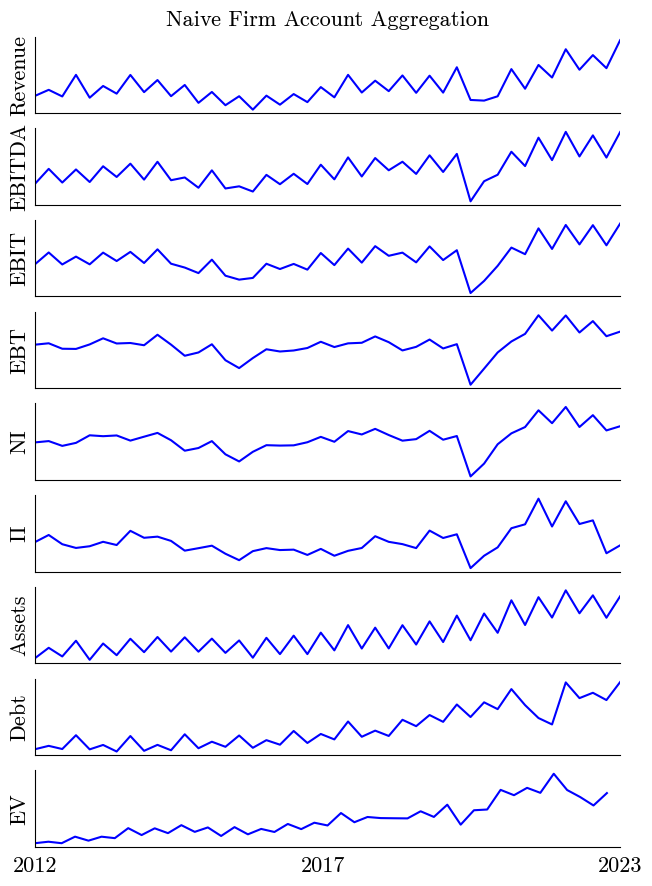

In [12]:
print('Observations:', len(tdfs[tdfs.Revenue > 0]), ';   Firms:', tdfs[tdfs.Revenue > 0].gvkey.nunique())

naive_agg = tdfs.groupby('datacqtr')[agg_cols].sum()
naive_agg = naive_agg[(naive_agg.index > '2011Q4') & (naive_agg.index < '2023Q1')]
naive_agg['datacqtr'] = naive_agg.index
naive_agg.index = naive_agg.datacqtr.apply(lambda x: cqtr_to_date(x, end=False))

display(naive_agg)
display(naive_agg.describe())

fig, ax = plt.subplots(len(naive_agg.columns[:-1]), figsize=(6.5, 9))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.suptitle('Naive Firm Account Aggregation', fontsize=16)
for i, col in enumerate(naive_agg.columns[:-1]):
    ax[i].plot(naive_agg[col], color='blue')
    ax[i].set_xlim(naive_agg.index.min(), naive_agg.index.max())
    ax[i].set_yticks([])
    ax[i].set_ylabel(agg_cols_names[col])
    if i == len(naive_agg.columns) - 2:
        ax[i].set_xticks([np.datetime64('2012-01-01'), np.datetime64('2017-06-01'), np.datetime64('2022-12-31')])
        ax[i].set_xticklabels(['2012', 2017, '2023'])
    else:
        ax[i].set_xticks([])
plt.savefig('Aggregates_time_series.svg')
plt.show()

### Refined Aggregation

Most basic filtering

- Reports non-zero revenue for all quarters where it is observed (drops all observations before that date for that firm if not true)
- Reports EBIT and net income for the same periods that they report Revenue
- Only examines ~2012 to ~2022

Observations: 57244 ;   Firms: 1301


,Revenue,EBITDA,EBIT,Pretax_Income,NI,Excess_Profit,Assets,Debt,Enterprise_Value,datacqtr
datacqtr,,,,,,,,,,
2012-01-01,2805202.584,520910.9270,382163.4620,323207.253,213741.096,104489.979437,2.275710e+07,8.590814e+06,1.951375e+07,2012Q1
2012-04-01,2792045.854,509077.0230,369418.8120,274216.531,185083.775,99241.994617,2.260668e+07,8.512328e+06,1.869141e+07,2012Q2
2012-07-01,2850771.777,523167.7590,374245.4670,283019.007,177143.811,98114.060605,2.297346e+07,8.588720e+06,1.938792e+07,2012Q3
2012-10-01,2899006.977,460715.3260,304893.5680,188717.500,153609.335,50701.838035,2.290746e+07,8.475490e+06,1.929586e+07,2012Q4
2013-01-01,2774049.582,518286.9090,371872.6060,323605.175,281274.693,85532.119006,2.305141e+07,8.526789e+06,2.016118e+07,2013Q1
2013-04-01,2837567.758,511714.6700,361447.2130,300109.746,198756.738,77466.271612,2.292089e+07,8.513953e+06,2.027759e+07,2013Q2
2013-07-01,2905791.345,541997.2700,386722.7110,332767.151,227336.591,135624.392578,2.324963e+07,8.612034e+06,2.086121e+07,2013Q3
2013-10-01,2945121.698,527611.4820,368160.8390,286701.781,203121.498,182407.568938,2.335727e+07,8.644695e+06,2.202917e+07,2013Q4
2014-01-01,2913098.116,536589.3540,378871.4970,319766.550,213331.844,100744.537705,2.350226e+07,8.735805e+06,2.241376e+07,2014Q1


,Revenue,EBITDA,EBIT,Pretax_Income,NI,Excess_Profit,Assets,Debt,Enterprise_Value
count,4.400000e+01,44.000000,44.000000,44.000000,44.000000,44.000000,4.400000e+01,4.400000e+01,4.400000e+01
mean,3.039345e+06,577043.565670,394641.106057,302770.535886,227101.737659,93148.815358,2.636593e+07,1.037242e+07,2.742036e+07
std,3.904092e+05,100520.843219,87057.195203,99380.406244,82627.258867,61031.716028,3.399678e+06,1.628940e+06,6.443375e+06
min,2.530828e+06,430969.435000,224719.114000,44775.071000,32904.882000,-22044.477496,2.260668e+07,8.475490e+06,1.869141e+07
25%,2.787547e+06,508909.219750,345144.293750,255457.716500,180716.415000,50567.775277,2.351045e+07,8.874123e+06,2.280028e+07
50%,2.912742e+06,542353.999000,381715.361500,299573.741000,213536.470000,82618.963257,2.522135e+07,1.003798e+07,2.615550e+07
75%,3.192164e+06,629934.245500,430443.250750,334027.021750,268038.891000,111319.213072,2.896346e+07,1.198962e+07,3.084061e+07
max,4.170140e+06,832075.840000,605125.466000,521636.964000,427005.015000,259487.418367,3.281481e+07,1.300390e+07,4.153879e+07


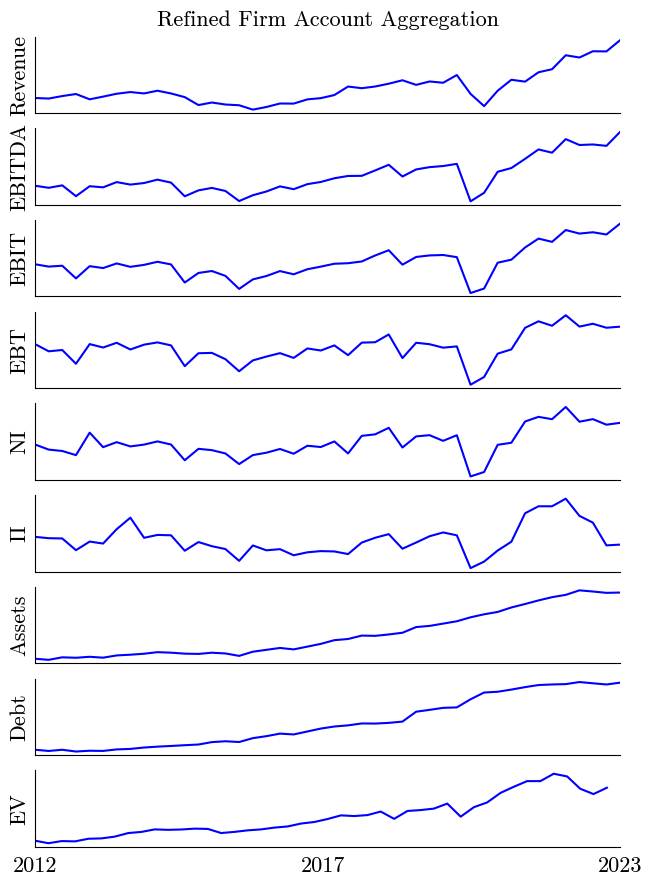

In [13]:
rdf = tdfs[(tdfs.datacqtr > '2011Q4') & (tdfs.datacqtr < '2023Q1')].copy().dropna(subset=agg_cols).copy()
rdf = pd.merge(rdf, rdf[agg_cols + ['gvkey']].groupby('gvkey').count().min(axis=1).rename('valid_vals'), left_on='gvkey', right_index=True)
rdf = rdf[rdf.valid_vals >= rdf.valid_vals.max()]

print('Observations:', len(rdf), ';   Firms:', rdf.gvkey.nunique())

rdf = rdf.groupby('datacqtr')[agg_cols].sum()
rdf = rdf[(rdf.index > '2011Q4') & (rdf.index < '2023Q1')]
rdf['datacqtr'] = rdf.index
rdf.index = rdf.datacqtr.apply(lambda x: cqtr_to_date(x, end=False))

display(rdf)
display(rdf.describe())

fig, ax = plt.subplots(len(rdf.columns[:-1]), figsize=(6.5, 9))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.suptitle('Refined Firm Account Aggregation', fontsize=16)
for i, col in enumerate(rdf.columns[:-1]):
    ax[i].plot(rdf[col], color='blue')
    ax[i].set_xlim(rdf.index.min(), rdf.index.max())
    ax[i].set_yticks([])
    ax[i].set_ylabel(agg_cols_names[col])
    if i == len(rdf.columns) - 2:
        ax[i].set_xticks([np.datetime64('2012-01-01'), np.datetime64('2017-06-01'), np.datetime64('2022-12-31')])
        ax[i].set_xticklabels(['2012', 2017, '2023'])
    else:
        ax[i].set_xticks([])
plt.savefig('Aggregates_time_series_refined.svg')
plt.show()

283008 10953
Revenue 240506 9052 44
EBITDA 200756 7845 44
EBIT 199201 7790 44
Pretax_Income 199054 7786 44
NI 198933 7782 44
Excess_Profit 107827 4301 44
Assets 107827 4301 44
Debt 107827 4301 44
Enterprise_Value 107827 4301 44
Observations: 107827 ;   Firms: 4301


,Revenue,EBITDA,EBIT,Pretax_Income,NI,Excess_Profit,Assets,Debt,Enterprise_Value,datacqtr
datacqtr,,,,,,,,,,
2012-01-01,3409501.747,630404.6970,459574.1820,374585.620,250512.040,124440.103851,2.821313e+07,1.170302e+07,2.485867e+07,2012Q1
2012-04-01,3425573.855,623878.0280,449615.1180,317521.391,213666.717,114200.806131,2.861366e+07,1.189825e+07,2.425924e+07,2012Q2
2012-07-01,3490215.748,640239.7280,455137.7670,329850.600,206861.326,112452.132266,2.906374e+07,1.196725e+07,2.516361e+07,2012Q3
2012-10-01,3575345.266,573643.8520,380547.0420,222591.263,184124.923,62328.562104,2.919912e+07,1.191407e+07,2.514510e+07,2012Q4
2013-01-01,3560695.745,655375.2920,468943.2260,390539.306,328806.024,100970.937889,2.966013e+07,1.205595e+07,2.687558e+07,2013Q1
2013-04-01,3642702.070,648639.0860,458307.4360,367381.677,242536.591,92347.054251,2.948861e+07,1.203263e+07,2.702911e+07,2013Q2
2013-07-01,3723205.645,684756.8840,487777.8130,401455.043,303339.247,147290.096056,2.990817e+07,1.213885e+07,2.788775e+07,2013Q3
2013-10-01,3780027.143,667091.1730,465077.7460,344965.650,241711.198,191867.473635,2.999647e+07,1.217166e+07,2.921718e+07,2013Q4
2014-01-01,3728046.690,678960.3290,478829.0250,388398.625,257017.391,118478.615619,3.014595e+07,1.224336e+07,2.967684e+07,2014Q1


,Revenue,EBITDA,EBIT,Pretax_Income,NI,Excess_Profit,Assets,Debt,Enterprise_Value
count,4.400000e+01,44.000000,44.000000,44.000000,44.000000,44.000000,4.400000e+01,4.400000e+01,4.400000e+01
mean,3.806058e+06,704840.113898,477941.179648,356504.684568,265905.979841,104939.193246,3.193338e+07,1.292294e+07,3.448632e+07
std,4.725346e+05,113976.050046,98726.736748,118379.035678,98773.333478,67856.379407,3.297793e+06,1.278947e+06,7.712693e+06
min,3.190935e+06,504543.760000,249205.206000,1295.556000,-10781.425000,-42683.520919,2.821313e+07,1.113580e+07,2.425924e+07
25%,3.478684e+06,626508.963500,420842.510750,304565.823250,217166.127750,61696.213865,2.965307e+07,1.201628e+07,2.916738e+07
50%,3.723833e+06,681715.788500,468359.632000,350028.098500,254110.713500,97061.404185,3.030748e+07,1.242216e+07,3.145893e+07
75%,3.959894e+06,762964.710500,513185.742250,402486.161250,313044.448250,131602.934702,3.395346e+07,1.410438e+07,3.819681e+07
max,5.147942e+06,976899.556000,699043.481000,617829.913000,506750.416000,287042.709308,3.848319e+07,1.511595e+07,5.248416e+07


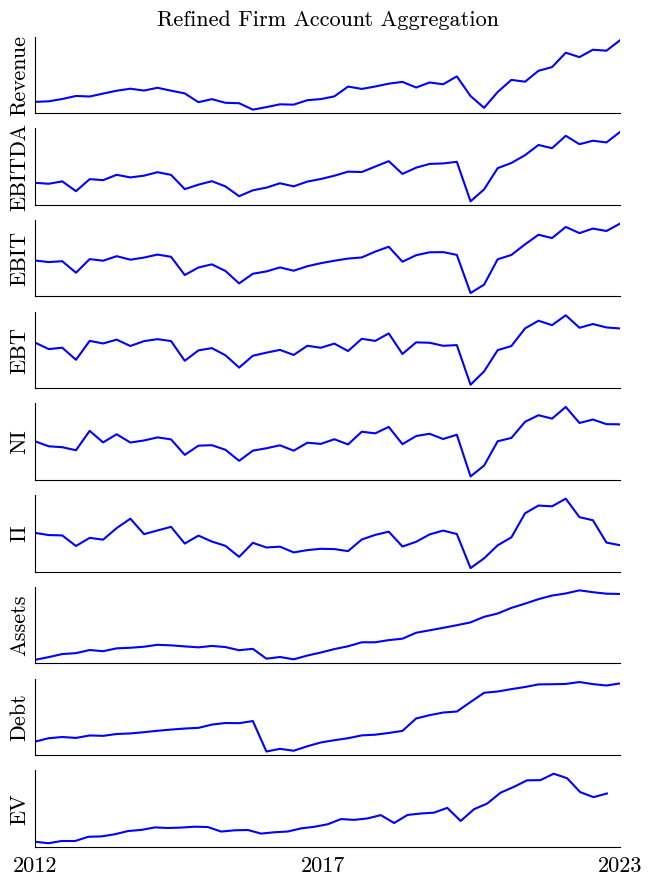

In [14]:
qdf = tdfs[(tdfs.datacqtr > '2011Q4') & (tdfs.datacqtr < '2023Q1')].copy()

print(len(qdf), qdf.gvkey.nunique())

for a in agg_cols:
    firstdate = qdf.groupby('gvkey')[a].apply(lambda x: qdf.loc[x.first_valid_index()].datadate if (x.isnull().any() and x.first_valid_index() != None) else qdf.loc[x.index[0]].datadate)
    lastdate = qdf.groupby('gvkey')[a].apply(lambda x: qdf.loc[x.last_valid_index()].datadate if (x.isnull().any() and x.last_valid_index() != None) else qdf.loc[x.index[-1]].datadate)
    qdf['firstvaliddate'] = pd.merge(qdf.gvkey, firstdate, left_on='gvkey', right_index=True, how='outer')[a]
    qdf['lastvaliddate'] = pd.merge(qdf.gvkey, lastdate, left_on='gvkey', right_index=True, how='outer')[a]
    qdf = qdf[(qdf.datadate >= qdf.firstvaliddate) & (qdf.datadate <= qdf.lastvaliddate)].copy()
    qdf['nas_account'] = pd.merge(qdf.gvkey, qdf.groupby('gvkey')[a].apply(lambda x: x.isna().sum()), left_on='gvkey', right_index=True, how='outer')[a]
    qdf = qdf[qdf.nas_account == 0].copy()
    qdf['obs'] = pd.merge(qdf.gvkey, qdf.groupby('gvkey')[a].count(), left_on='gvkey', right_index=True, how='outer')[a]
    qdf = qdf[qdf.obs > 1].copy()
    print(a, len(qdf), qdf.gvkey.nunique(), qdf.datacqtr.nunique())



print('Observations:', len(qdf), ';   Firms:', qdf.gvkey.nunique())

qdf = qdf.groupby('datacqtr')[agg_cols].sum()
qdf = qdf[(qdf.index > '2011Q4') & (qdf.index < '2023Q1')]
qdf['datacqtr'] = qdf.index
qdf.index = qdf.datacqtr.apply(lambda x: cqtr_to_date(x, end=False))

display(qdf)
display(qdf.describe())

fig, ax = plt.subplots(len(qdf.columns[:-1]), figsize=(6.5, 9))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.suptitle('Refined Firm Account Aggregation', fontsize=16)
for i, col in enumerate(qdf.columns[:-1]):
    ax[i].plot(qdf[col], color='blue')
    ax[i].set_xlim(qdf.index.min(), qdf.index.max())
    ax[i].set_yticks([])
    ax[i].set_ylabel(agg_cols_names[col])
    if i == len(qdf.columns) - 2:
        ax[i].set_xticks([np.datetime64('2012-01-01'), np.datetime64('2017-06-01'), np.datetime64('2022-12-31')])
        ax[i].set_xticklabels(['2012', 2017, '2023'])
    else:
        ax[i].set_xticks([])
plt.savefig('Aggregates_time_series_refined_inandout.svg')
plt.show()

### National Income Accounts

ALL for **non-financial corporate businesses** (except for those notated with *)

- Nominal GDP*: `NGDPSAXDCUSQ`
- Debt: `TCMILBSNNCB`
- Debt as % of market value: `NCBCMDPMVCE`
- Profits Before Tax (without IVA and CCAdj): `BOGZ1FU106060005Q`
- Profits Before Tax with IVA and CCAdj: `BOGZ1FU106060035Q`
- Total Assets: `TABSNNCB`
- Total Liabilities: `TLBSNNCB`
- Interest Paid (transactions): `BOGZ1FU106130001Q`
- Total CapEx (transactions): `BOGZ1FU105050005Q`
- Gross Value Added of Nonfinancial Corporate Businesses: `BOGZ1FU106902501Q`
- Net Value Added of Nonfinancial Corporate Businesses: `BOGZ1FU106902605Q`
- Revenue, Excluding Indirect Sales Taxes, (transactions): `BOGZ1FU106030005Q`
- Earnings Before Interest and Tax: `BOGZ1FU106110115Q`
- Retained Earnings: `BOGZ1FU106110405Q`
- Taxes on Corporate Income: `BOGZ1FU106231005Q`


<br/>

Use the following URL and add filters as needed: 

https://fred.stlouisfed.org/searchresults/?st=nonfinancial&t=nsa%3Bnonfinancial%3Bquarterly%3Btax&rt=tax&ob=sr

In [18]:
fdf = FRED('NGDPSAXDCUSQ')

fred_cols = {
    'NGDP': 'NGDPSAXDCUSQ',
    'Debt': 'TCMILBSNNCB',
    'Debt_as_pct_of_mkt_val': 'NCBCMDPMVCE',
    'Profitspretax_NOIVACC': 'BOGZ1FU106060005Q', 
    'Profits_pretax_IVACC': 'BOGZ1FU106060035Q',
    'Assets': 'TABSNNCB',
    'Liabilities': 'TLBSNNCB',
    'Interest_Exp': 'BOGZ1FU106130001Q',
    'CapEx': 'BOGZ1FU105050005Q',
    'GVA': 'BOGZ1FU106902501Q',
    'NVA': 'BOGZ1FU106902605Q',
    'Revenue': 'BOGZ1FU106030005Q',
    'EBIT': 'BOGZ1FU106110115Q',
    'Retained_Earnings': 'BOGZ1FU106110405Q',
    'Income_Taxes': 'BOGZ1FU106231005Q'
}

for col in list(fred_cols.keys())[1:]:
    fdf = pd.merge(fdf, FRED(fred_cols[col]), left_index=True, right_index=True, how='outer')

fdf.columns = list(fred_cols.keys())

fdf = fdf.replace('.', np.nan)
fdf = fdf.astype('float64')

fdf['Enterprise_Value'] = fdf.Debt / fdf.Debt_as_pct_of_mkt_val
fdf.drop(['Debt_as_pct_of_mkt_val'], axis=1, inplace=True)

fdf['Profits_aftertax_NOIVACC'] = fdf['Profitspretax_NOIVACC']
fdf['Profits_aftertax_IVACC'] = fdf['Profits_pretax_IVACC']

display(fdf)
display(fdf.describe())

,NGDP,Debt,Profitspretax_NOIVACC,Profits_pretax_IVACC,Assets,Liabilities,Interest_Exp,CapEx,GVA,NVA,Revenue,EBIT,Retained_Earnings,Income_Taxes,Enterprise_Value,Profits_aftertax_NOIVACC,Profits_aftertax_IVACC
DATE,,,,,,,,,,,,,,,,,
1945-10-01,NaN,44.653,NaN,NaN,286.179,87.067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.048788,NaN,NaN
1946-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-10-01,NaN,49.889,22603.0,23843.0,311.970,99.374,1568.0,19182.0,100771.0,93019.0,100771.0,17972.0,3050.0,8573.0,0.984771,22603.0,23843.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,6602101.3,13439.307,583413.0,1150021.0,57551.206,26730.841,108023.0,630038.0,3387843.0,2870268.0,3387843.0,753515.0,236431.0,104450.0,507.475639,583413.0,1150021.0
2023-01-01,6703400.3,13633.558,593479.0,1136240.0,58425.661,26824.723,108023.0,709599.0,3423298.0,2892906.0,3423298.0,696680.0,210289.0,109359.0,546.815817,593479.0,1136240.0
2023-04-01,6765753.0,13668.064,605514.0,1144789.0,59462.313,26977.134,108023.0,640532.0,3460327.0,2922062.0,3460327.0,715140.0,225181.0,107591.0,590.021975,605514.0,1144789.0


,NGDP,Debt,Profitspretax_NOIVACC,Profits_pretax_IVACC,Assets,Liabilities,Interest_Exp,CapEx,GVA,NVA,Revenue,EBIT,Retained_Earnings,Income_Taxes,Enterprise_Value,Profits_aftertax_NOIVACC,Profits_aftertax_IVACC
count,2.960000e+02,295.000000,294.000000,2.940000e+02,295.000000,295.000000,294.000000,294.000000,2.930000e+02,2.930000e+02,2.930000e+02,294.000000,294.00000,294.000000,295.000000,294.000000,2.940000e+02
mean,1.859702e+06,3328.871644,126698.037415,2.930471e+05,14833.476512,7048.273749,59275.996599,183164.816327,9.497371e+05,8.137249e+05,9.497371e+05,204327.173469,60337.64966,29356.105442,102.272990,126698.037415,2.930471e+05
std,1.851813e+06,3686.562318,148251.264035,3.068094e+05,16011.048070,7639.514560,50110.923844,185042.277835,9.143874e+05,7.722776e+05,9.143875e+05,200207.483528,64275.11389,25118.284513,145.040328,148251.264035,3.068094e+05
min,7.020700e+04,44.653000,7227.000000,1.154700e+04,286.179000,87.067000,636.000000,5387.000000,4.535100e+04,4.149200e+04,4.535100e+04,7991.000000,1847.00000,3508.000000,0.955271,7227.000000,1.154700e+04
25%,2.366762e+05,281.467000,19258.250000,3.603525e+04,1304.133000,765.933000,4470.000000,23295.250000,1.400200e+05,1.264750e+05,1.400200e+05,26371.250000,9019.50000,7990.500000,6.717873,19258.250000,3.603525e+04
50%,1.172473e+06,1920.462000,56855.000000,1.732990e+05,8754.638000,3819.062000,60318.000000,116690.000000,6.382390e+05,5.563370e+05,6.382390e+05,136383.500000,32412.50000,21357.000000,25.222804,56855.000000,1.732990e+05
75%,3.244413e+06,5402.907000,190881.750000,4.951048e+05,26731.095500,11465.993000,108023.000000,293171.750000,1.634086e+06,1.407863e+06,1.634086e+06,341106.500000,94661.00000,44164.750000,156.223026,190881.750000,4.951048e+05
max,6.984708e+06,13689.088000,653755.000000,1.164973e+06,59751.311000,27320.312000,153181.000000,770028.000000,3.510409e+06,2.966046e+06,3.510410e+06,753515.000000,256834.00000,110318.000000,647.609699,653755.000000,1.164973e+06


In [19]:
fdf = fdf[fdf.index.isin(naive_agg.index)].copy()
fdf.describe()

,NGDP,Debt,Profitspretax_NOIVACC,Profits_pretax_IVACC,Assets,Liabilities,Interest_Exp,CapEx,GVA,NVA,Revenue,EBIT,Retained_Earnings,Income_Taxes,Enterprise_Value,Profits_aftertax_NOIVACC,Profits_aftertax_IVACC
count,4.400000e+01,44.000000,44.000000,4.400000e+01,44.000000,44.000000,44.000000,44.000000,4.400000e+01,4.400000e+01,4.400000e+01,44.000000,44.000000,44.000000,44.000000,44.000000,4.400000e+01
mean,5.006678e+06,9777.937023,381111.431818,8.324754e+05,42253.134500,20754.345886,118396.181818,505284.340909,2.514912e+06,2.127857e+06,2.514912e+06,534622.795455,168081.272727,65763.272727,362.067404,381111.431818,8.324754e+05
std,7.083759e+05,2020.588927,103612.920329,1.334863e+05,8707.044985,3562.102416,12490.771074,82164.052879,3.811959e+05,3.247134e+05,3.811959e+05,85598.816806,29354.605543,15440.920381,121.923559,103612.920329,1.334863e+05
min,4.017201e+06,6774.962000,292100.000000,6.729540e+05,29559.709000,15088.642000,106762.000000,368804.000000,2.003017e+06,1.699511e+06,2.003017e+06,338741.000000,100758.000000,44210.000000,190.918736,292100.000000,6.729540e+05
25%,4.471279e+06,8102.621500,323510.000000,7.510532e+05,35406.114250,17690.905750,108023.000000,440501.250000,2.266847e+06,1.923330e+06,2.266847e+06,485635.250000,151265.250000,54287.750000,282.304814,323510.000000,7.510532e+05
50%,4.891405e+06,9371.367000,335283.500000,7.779065e+05,41343.975000,20318.786000,114381.000000,501474.000000,2.415895e+06,2.043484e+06,2.415895e+06,512264.000000,163841.000000,64517.000000,333.867094,335283.500000,7.779065e+05
75%,5.424335e+06,11727.185750,365820.500000,8.743180e+05,48449.920750,24386.571500,125402.000000,547877.500000,2.706911e+06,2.281628e+06,2.706911e+06,546584.000000,185081.250000,72947.750000,420.198692,365820.500000,8.743180e+05
max,6.602101e+06,13439.307000,653755.000000,1.150021e+06,57679.123000,26730.841000,148472.000000,770028.000000,3.387843e+06,2.870284e+06,3.387843e+06,753515.000000,236431.000000,106117.000000,647.609699,653755.000000,1.150021e+06


In [20]:
qmdf = pd.merge(qdf[qdf.columns[:-1]].pct_change().add_suffix('_WRDS'), fdf.pct_change().add_suffix('_MACRO'), left_index=True, right_index=True)

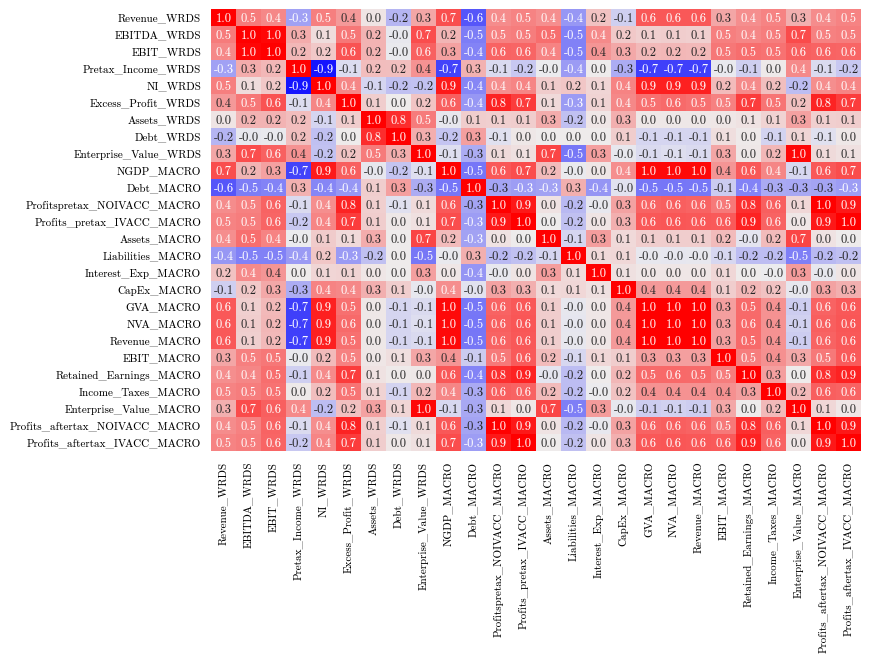

,Sum of Correlations
Revenue_WRDS,7.673261
EBITDA_WRDS,8.913875
EBIT_WRDS,9.939837
Pretax_Income_WRDS,-2.507500
NI_WRDS,6.971835
Excess_Profit_WRDS,10.401200
Assets_WRDS,4.694390
Debt_WRDS,1.856008
Enterprise_Value_WRDS,5.449961
NGDP_MACRO,9.652735


In [21]:
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

hc = ['#0000FF', '#EEEEEE', '#FF0000']
th = [0, 0.5, 1]


data_correlation = qmdf.corr()


cdict = NonLinCdict(th, hc)
cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)

fig, ax = plt.subplots(figsize=(10, 6.5))
plt.subplots_adjust(left=0.2, right=0.85, top=0.98, bottom=0.30)

ax = sns.heatmap(data_correlation, vmin=-1, vmax=1, cmap=cm, annot=True, fmt='.1f'.lstrip('0'), cbar=False, annot_kws={"size":9})
ax.set_xticks(np.linspace(0,len(data_correlation.columns)-1, len(data_correlation.columns))+0.5)
ax.set_xticklabels(list(data_correlation.columns), fontsize=8)
ax.set_yticks(np.linspace(0,len(data_correlation.columns)-1, len(data_correlation.columns))+0.5)
ax.set_yticklabels(list(data_correlation.columns), fontsize=8, verticalalignment='center')

plt.savefig('wrds_macro_corr.svg')
plt.show()

display(pd.DataFrame(data_correlation.sum(), columns=['Sum of Correlations']))

In [22]:
qmdf.to_csv('refined_inandout_fred_merged.csv')

In [ ]:
series = 'EBIT_WRDS'

applicable_macro = ['']

In [ ]:
data_correlation_ps = calculate_pvalues(qmdf)

cdict = NonLinCdict(th, hc)
cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)

fig, ax = plt.subplots(figsize=(11, 6.5))
plt.subplots_adjust(left=0.3, right=0.8, top=0.98, bottom=0.30)

ax = sns.heatmap(data_correlation_ps, vmin=-1, vmax=1, cmap=cm, annot=True, fmt='.1f'.lstrip('0'), cbar=False, annot_kws={"size":9})
ax.set_xticklabels(list(data_correlation_ps.columns), fontsize=9)
ax.set_yticks(np.linspace(0,len(data_correlation_ps.columns)-1, len(data_correlation_ps.columns))+0.5)
ax.set_yticklabels(list(data_correlation_ps.columns), fontsize=9, verticalalignment='center')

plt.show()

## Regressions

In [ ]:
`var = 'NGDP_MACRO'  # To test against WRDS revenue

revmod = smf.ols('Revenue_WRDS ~ ' + var, data=rmdf).fit()
display(revmod.summary())`

In [ ]:
var = 'NGDP_MACRO'  # To test against WRDS revenue

revmod = smf.ols('EBIT_WRDS ~ ' + var, data=rmdf).fit()
display(revmod.summary())

In [ ]:
naive_agg.Revenue / fdf.NGDP

In [ ]:
list(tdfs)

In [ ]:
tdfs.sort_values('Revenue', ascending=False)[['tic','conm','Revenue','datadate']].head(60)

End of Notebook.